For the purpose of this demonstration, we will place a simple order to the Orders API that will return us some Non Cloud Optimized GeoTIFFs. First, we'll use the Data API to do a quick search of the Planet catalog for PSScene4Band items, filtering by a specific AOI and TOI. We will take the item id's returned from that search to submit a simple order to the Orders API. We'll download an analytic bundle containing the GeoTIFFs, udms, and xml files, focusing our attention on just the GeoTIFFs so we can inspect them and convert them to COGs. 

### Import Dependencies

In [3]:
import requests
import os
from requests.auth import HTTPBasicAuth
import json
import pathlib
from rio_cogeo.cogeo import cog_translate
from rio_cogeo.profiles import cog_profiles

---

### Authentication

In [4]:
## Get Planet API key stored as an environment variable on your system
PLANET_API_KEY = os.getenv('PLANET_API_KEY')

## HTTP Basic Authentication
planet_auth = HTTPBasicAuth(PLANET_API_KEY, '')

In [5]:
# set content type to json
headers = {'content-type': 'application/json'}

---

### Create a Search with Planet's Data API

In [6]:
# Quick Search endpoint
BASE_URL="https://api.planet.com/data/v1"
quick_search_url = "{}/quick-search".format(BASE_URL)
print(quick_search_url)

https://api.planet.com/data/v1/quick-search


In [7]:
## Search for items that intersect the specified geometry. The AOI is centered around midtown Manhattan
geom_filter = {
    "type": "GeometryFilter",
    "field_name": "geometry",
    "config": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -73.98674011230469,
              40.7555146258563
            ],
            [
              -73.93670082092285,
              40.7555146258563
            ],
            [
              -73.93670082092285,
              40.80542887583346
            ],
            [
              -73.98674011230469,
              40.80542887583346
            ],
            [
              -73.98674011230469,
              40.7555146258563
            ]
          ]
        ]  
    }
}

# Apply a date range filter for imagery. Return all imagery aquired after May 11th, 2021 and on or before 
# May 17th, 2021
date_range_filter = {
    "type": "DateRangeFilter",
    "field_name": "acquired",
    "config": {
        "gt": "2021-05-11T00:00:00Z",
        "lte": "2021-05-17T00:00:00Z"
    } 
}

#Apply a range filter looking at imagery that has cloud cover less than 20 percent
range_filter ={
    "type": "RangeFilter",
    "field_name": "cloud_cover",
    "config": {
        "lte": 0.2
    }
}

# Filter imagery with an AOI around midtown Manhattan aquired after May 10th, 2021 and on or before May 13th, 2021 
# with less than 20 percent cloud coverage
combined_filters = {
    "type": "AndFilter",
    "config": [geom_filter, date_range_filter, range_filter]
}

In [8]:
print(json.dumps(combined_filters, indent=2))

{
  "type": "AndFilter",
  "config": [
    {
      "type": "GeometryFilter",
      "field_name": "geometry",
      "config": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -73.98674011230469,
              40.7555146258563
            ],
            [
              -73.93670082092285,
              40.7555146258563
            ],
            [
              -73.93670082092285,
              40.80542887583346
            ],
            [
              -73.98674011230469,
              40.80542887583346
            ],
            [
              -73.98674011230469,
              40.7555146258563
            ]
          ]
        ]
      }
    },
    {
      "type": "DateRangeFilter",
      "field_name": "acquired",
      "config": {
        "gt": "2021-05-11T00:00:00Z",
        "lte": "2021-05-17T00:00:00Z"
      }
    },
    {
      "type": "RangeFilter",
      "field_name": "cloud_cover",
      "config": {
        "lte": 0.2
      }
    }


In [9]:
# Create the request object for PSScene4Band Imagery
search_request_4Band={
    "item_types": ["PSScene4Band"],
    "filter": combined_filters
}

In [10]:
search_result_4Band = \
  requests.post(
    quick_search_url,
    auth=planet_auth,
    json=search_request_4Band)

print(json.dumps(search_result_4Band.json(), indent=1))

{
 "_links": {
  "_first": "https://api.planet.com/data/v1/searches/a6a765f52fcb49e39386f3007fdea4b9/results?_page=eyJwYWdlX3NpemUiOiAyNTAsICJzb3J0X2J5IjogInB1Ymxpc2hlZCIsICJzb3J0X2Rlc2MiOiB0cnVlLCAic29ydF9zdGFydCI6IG51bGwsICJzb3J0X2xhc3RfaWQiOiBudWxsLCAic29ydF9wcmV2IjogZmFsc2UsICJxdWVyeV9wYXJhbXMiOiB7fX0%3D",
  "_next": "https://api.planet.com/data/v1/searches/a6a765f52fcb49e39386f3007fdea4b9/results?_page=eyJwYWdlX3NpemUiOiAyNTAsICJzb3J0X2J5IjogInB1Ymxpc2hlZCIsICJzb3J0X2Rlc2MiOiB0cnVlLCAic29ydF9zdGFydCI6ICIyMDIxLTA1LTEyVDIzOjU5OjMyLjAwMDAwMFoiLCAic29ydF9sYXN0X2lkIjogIjIwMjEwNTEyXzE0NTYzNF83NV8yMjM1IiwgInNvcnRfcHJldiI6IGZhbHNlLCAicXVlcnlfcGFyYW1zIjoge319",
  "_self": "https://api.planet.com/data/v1/searches/a6a765f52fcb49e39386f3007fdea4b9/results?_page=eyJwYWdlX3NpemUiOiAyNTAsICJzb3J0X2J5IjogInB1Ymxpc2hlZCIsICJzb3J0X2Rlc2MiOiB0cnVlLCAic29ydF9zdGFydCI6IG51bGwsICJzb3J0X2xhc3RfaWQiOiBudWxsLCAic29ydF9wcmV2IjogZmFsc2UsICJxdWVyeV9wYXJhbXMiOiB7fX0%3D"
 },
 "features": [
  {
   "_links": {
 

---

### Submit an Order with the Planet Orders API

In [14]:
# Item id's for PSScene4Band Imagery obtained from our search. We can now use these item id's in 
# preparing our order
item_selection = [feature['id'] for feature in search_result_4Band.json()['features']]
item_selection

['20210515_145754_03_245c',
 '20210515_145751_73_245c',
 '20210514_145807_70_2455',
 '20210514_145805_22_2455',
 '20210514_154816_78_227b',
 '20210513_152348_101f',
 '20210513_152347_101f',
 '20210513_150713_64_1067',
 '20210513_150715_17_1067',
 '20210512_152647_0f15',
 '20210512_152646_0f15',
 '20210512_152222_1014',
 '20210512_152221_1014',
 '20210512_145636_96_2235',
 '20210512_145634_75_2235']

In [13]:
# Base Order URL
planet_orders_url = 'https://api.planet.com/compute/ops/orders/v2'

In [15]:
# Prepare a simple order
def prepare_simple_order(order_name, item_list, item_type, bundle_selection):
    order_request = {  
       "name":order_name,
       "products":[
          {  
             "item_ids": item_list,
             "item_type":item_type,
             "product_bundle":bundle_selection
          }
       ]
    }
    return order_request

In [16]:
def submit_simple_order(order_name, order_items, base_order_url, auth, item_type, bundle_selection):
    
    # Prepare the order request
    order_request = prepare_simple_order(order_name, order_items, item_type, bundle_selection)
    print(json.dumps(order_request, indent=2))
    
    # Place the order
    order_response = requests.post(base_order_url, json.dumps(order_request), auth=auth, headers=headers)
    print(order_response)
    return order_response

In [ ]:
order_response = submit_simple_order("analytic_order", item_selection, planet_orders_url , planet_auth, "PSScene4Band", "analytic")

In [ ]:
# Append current order id to the base orders URL. Replace with your own order id
current_order_url = planet_orders_url + '/' + 'cb363b75-b4e4-46f1-8d32-0ef87afb6215'

In [ ]:
order_response = requests.get(current_order_url, auth=planet_auth)

In [ ]:
order_results =order_response.json()["_links"]["results"]
order_results

---

### Conversion to COGs

In [17]:
# Create a directory to store the regular geotiffs from our order results
def download_geotiffs(order_results, directory_name):
  
    # Create a directory to store regular geotiffs inside your current working directory
    regular_geotiff_folder = pathlib.Path.cwd() / directory_name
    try:
        regular_geotiff_folder.mkdir(parents=True, exist_ok=False)
        print("Directory to store regular geotiffs has been made")
    except FileExistsError:
        print("Directory to store regular geotiffs already exists")
   
    # get all the analytic image result names
    order_names = [order['name'] for order in order_results if order['name'].endswith('AnalyticMS.tif')]
    
    
    # get the locations for the analytic images
    order_locations = [order['location'] for order in order_results if order['name'].endswith('AnalyticMS.tif')]
    for order_name, order_location in zip(order_names, order_locations):
        geotiff_file_path = pathlib.Path.joinpath(regular_geotiff_folder).joinpath(order_name)
        geotiff_file_path.parent.mkdir(parents=True, exist_ok=True)
        geotiff_download = requests.get(order_location, allow_redirects=True)
        open(geotiff_file_path, 'wb').write(geotiff_download.content)

In [18]:
# Create another directory to store COGs after conversion
def cog_convert(geotiff_directory, order_id, cog_directory_name, item_type):
  
    cog_path = pathlib.Path.cwd() / cog_directory_name
    try:
        cog_path.mkdir(parents=True, exist_ok=False)
        print("Directory to store newly created cogs has been made")
    except FileExistsError:
        print("Directory to store newly created cogs already exists")
    
    geotiff_file_path = pathlib.Path.cwd() / geotiff_directory / order_id / item_type 

    for filename in os.listdir(geotiff_file_path):
        src_path = pathlib.Path.joinpath(geotiff_file_path).joinpath(filename)
        dst_path = pathlib.Path.joinpath(cog_path).joinpath(filename) 
        cog_translate(src_path, dst_path, cog_profiles.get("deflate"))

In [19]:
def cog_conversion_from_order(planet_orders_url, order_id, item_type, planet_auth, original_tiff_path, cog_path):
    
    # Get the user's current order id and append to the base order URL
    current_order_url = planet_orders_url + '/' + order_id
    
    # Get array of results from the current order 
    order_response = requests.get(current_order_url, auth=planet_auth).json()
    order_results = order_response["_links"]["results"]
    
    # From the order results, download our GeoTIFFs and store in directory
    download_geotiffs(order_results, original_tiff_path)
    
    # Convert this directory of GeoTIFFs to COGs and store in separate directory
    cog_convert(original_tiff_path, order_id, cog_path, item_type)
    

In [ ]:
cog_conversion_from_order(planet_orders_url, "edc43923-3ecd-4ee4-932a-e19360522af9", "PSScene4Band", planet_auth, "geotiff",  "cog")

---

### Inspecting and Converting GeoTIFFs and COGs Using rio-cogeo

rio-cogeo is a rasterio plugin for the creation and validation of COGs. It is a pretty neat tool! It has both a CLI and an API to work with. Below we will use the command line to take one of our non cloud optimzed GeoTIFFs from our submitted order and learn more about the details of the format. We can then use the plugin to convert it into a COG and inspect the data and compare the differences.

For the GeoTIFF below, we can see that it is internally tiled and has multiple overviews. However, its offset values for the IFD of the main image as well as the first overview illustrate that the internal structure of the GeoTIFF is not stored as contigious blocks as highlighted in the diagram earlier in this tutorial. Therefore, it is not a valid COG.

### Ordinary GeoTIFF

command: <b>rio cogeo info <example_input.tif</b>

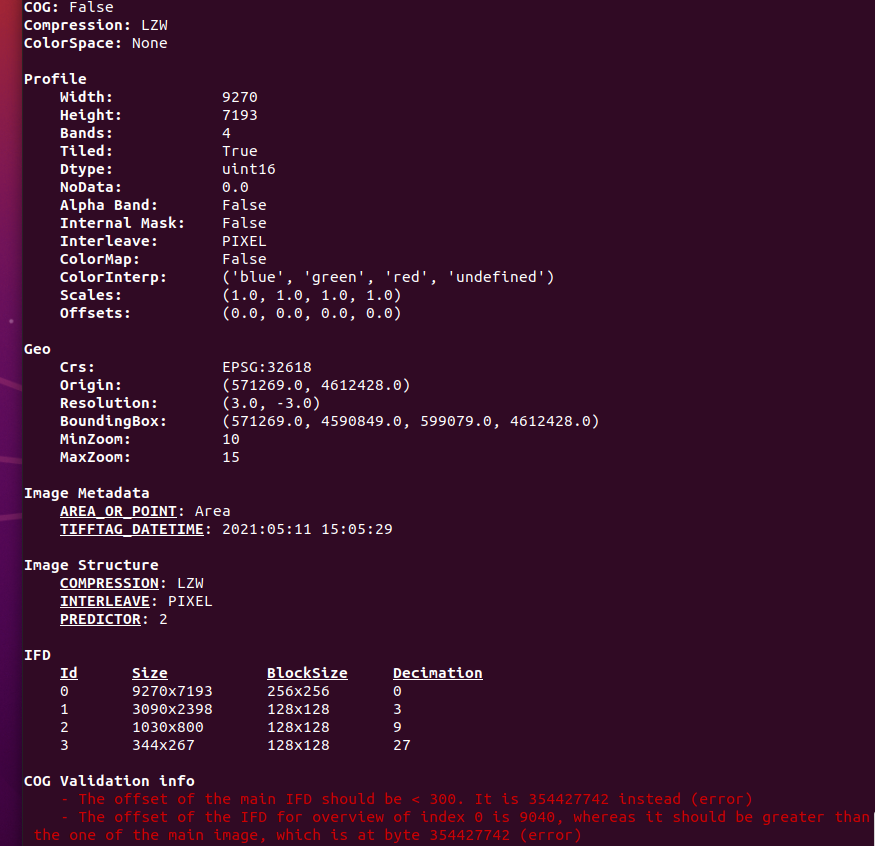

### COG

command: <b>rio cogeo create <example_input.tif> <example_output.tif</b>

Now, let's go look at the converted COG version of this GeoTIFF from our Cogs directory that we created. We can now see that the IFDs and the image data are stored contigously making it a valid COG.

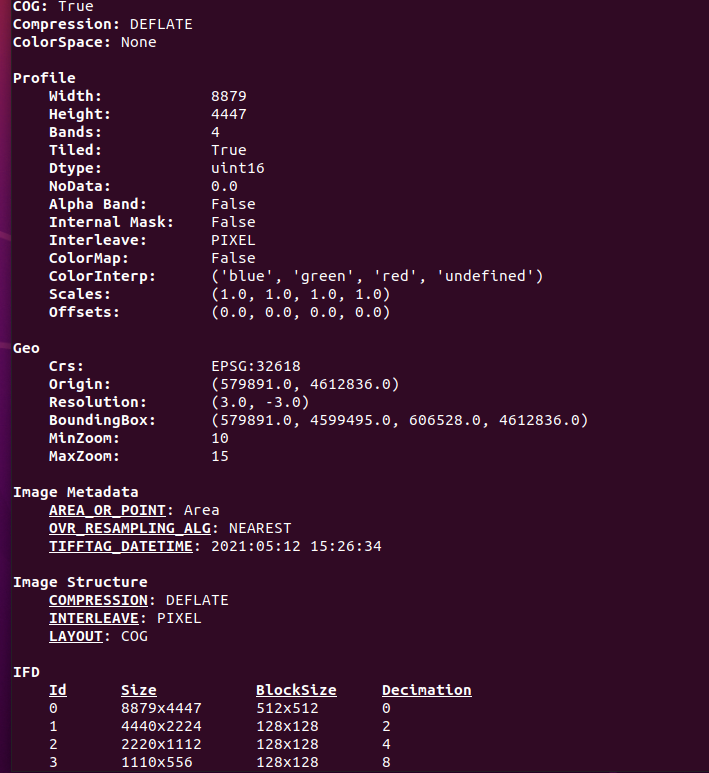

---

### Converting GeoTIFFs and COGs Using GDAL

The GDAL command line interface can also be used to quickly create a COG. You need to specify the form of compression used(LZW or Deflate) and also require internal tiling to be present.

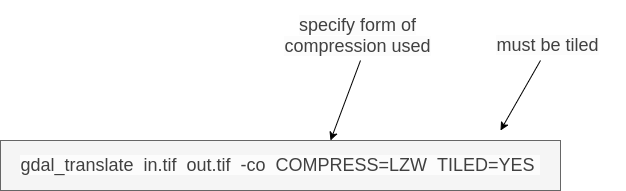

To create a set of overviews, you can use the gdaladdo command. This command would need to be executed before gdal_translate to create a valid COG.

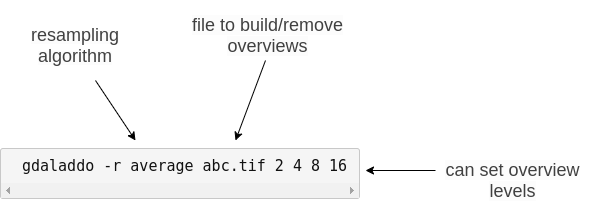

---

### Up Next

In the next tutorial, we will provide an introduction to Google Cloud and Dynamic Web Tiling with COGs!